# Distracted Driver Detection

## Include Dependency

In [1]:
#import

import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import random
import time
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize

from keras.layers import *
from keras.models import Model
import h5py


/home/john/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Import data

Define a load_train function to load the image from the file path of the data

In [2]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'data','imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2_resize(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers

## Sample Data Display

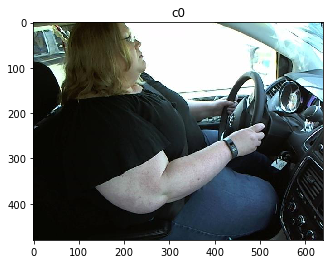

In [3]:
path = os.path.join( 'data','imgs', 'train', 'c0', 'img_104.jpg')
import matplotlib.image as mpimg
img=mpimg.imread(path)
#resized = cv2.resize(img, (100, 80), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(img)
plt.show()

## Data Preprocessing

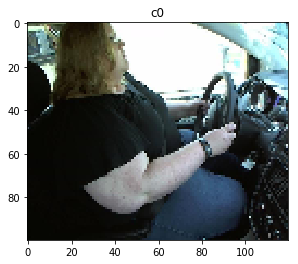

In [4]:
resized = cv2.resize(img, (120, 100), cv2.INTER_LINEAR)
plt.title('c0')
plt.imshow(resized)
plt.show()

In [5]:
def get_im_cv2_resize(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized

## Create training Set

Load the data and resize to create training set.

In [6]:
def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, color_type)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


In [7]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def get_driver_data():
    dr = dict()
    path = os.path.join( 'data', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/imgs/train/',
        target_size=(100, 80),
        batch_size=32,
        class_mode='categorical')

Found 22424 images belonging to 10 classes.


In [9]:
img_rows, img_cols = 120, 100
batch_size = 32
nb_epoch = 20
random_state = 51

use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3
 
train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)

Restore train from cache!
Train shape: (22424, 120, 100, 3)
22424 train samples


## Training Model Design

In [9]:
from keras.applications.vgg16 import VGG16

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
input = Input(shape=(120,100,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

#Create your own model 
model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model.summary()
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


In [10]:
def train_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    #model_vgg16_conv.summary()

    #Create your own input format (here 3x200x200)
    input = Input(shape=(120,100,3),name = 'image_input')

    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(input)

    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    #Create your own model 
    model = Model(input=input, output=x)

    #In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
    #model.summary()
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Model Visualization

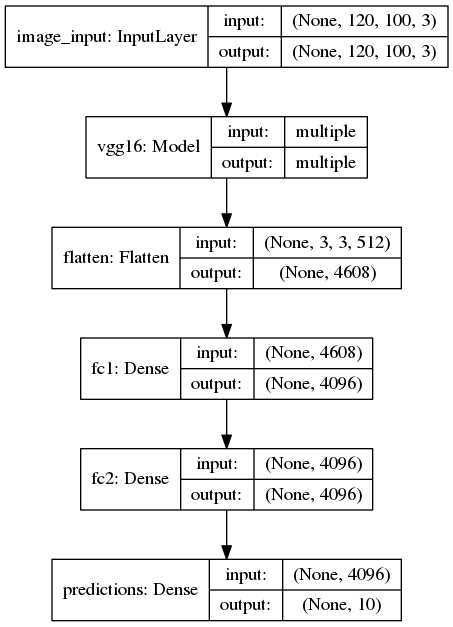

In [27]:
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import Image, SVG

plot_model(model,show_shapes=True)
Image(filename = 'model.png')

## Train Model and Save

In [12]:
np.random.seed(2016)

num_fold=0
nfolds=5
restore_from_last_checkpoint = 1

#X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

kf = KFold(train_data.shape[0], n_folds=nfolds, shuffle=True,random_state=random_state)

for train, test in kf:
    model = train_model()
    X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size=0.2, random_state=42)
    
    num_fold += 1
    print('Start KFold number {} from {}'.format(num_fold, nfolds))
    print('Split train: ', len(X_train), len(y_train))
    print('Split valid: ', len(X_val), len(y_val))
    #print('Train drivers: ', unique_list_train)
    #print('Test drivers: ', unique_list_valid)
    
    kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_' + str(num_fold) + '.h5')
    if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
            callbacks = [
                #EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
            ]
            model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20,
                  shuffle=True, verbose=1, validation_data=(X_val, y_val),
                  callbacks=callbacks)
    
         
"""
filepath = "weights.best.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list=[checkpoint]
model.fit(X_train, Y_train, batch_size=batch_size, epochs=100,
               verbose=2, validation_data=(X_valid, Y_valid), callbacks = callbacks_list)
"""
"""
model=train_model()
filepath = "weights.best.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list=[checkpoint]
model.fit_generator(train_generator, steps_per_epoch=100, epochs=20,
               verbose=2, callbacks = callbacks_list)
"""

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


Start KFold number 1 from 5
Split train:  17939 17939
Split valid:  4485 4485


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 17939 samples, validate on 4485 samples
Epoch 1/20
17939/17939 [==============================] - 356s - loss: 0.3594 - acc: 0.8843 - val_loss: 0.0930 - val_acc: 0.9710
Epoch 2/20
17939/17939 [==============================] - 353s - loss: 0.0376 - acc: 0.9891 - val_loss: 0.0331 - val_acc: 0.9924
Epoch 3/20
17939/17939 [==============================] - 353s - loss: 0.0217 - acc: 0.9939 - val_loss: 0.0353 - val_acc: 0.9909
Epoch 4/20
17939/17939 [==============================] - 353s - loss: 0.0143 - acc: 0.9955 - val_loss: 0.0413 - val_acc: 0.9875
Epoch 5/20
17939/17939 [==============================] - 353s - loss: 0.0147 - acc: 0.9959 - val_loss: 0.0260 - val_acc: 0.9933
Epoch 6/20
17939/17939 [==============================] - 352s - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0193 - val_acc: 0.9955
Epoch 7/20
17939/17939 [==============================] - 351s - loss: 0.0132 - acc: 0.9964 - val_loss: 0.0449 - val_acc: 0.9891
Epoch 8/20
17939/17939 [========================

'\nmodel=train_model()\nfilepath = "weights.best.hdf5"\nfrom keras.callbacks import ModelCheckpoint\ncheckpoint = ModelCheckpoint(filepath, monitor=\'val_loss\', verbose=1, save_best_only=True, mode=\'auto\')\ncallbacks_list=[checkpoint]\nmodel.fit_generator(train_generator, steps_per_epoch=100, epochs=20,\n               verbose=2, callbacks = callbacks_list)\n'

## Save Model

## Evaluation

## Prediction

In [25]:
img_rows, img_cols = 120, 100
batch_size = 32
nb_epoch = 20
random_state = 51

use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3

In [23]:
def load_test(part):
    path = os.path.join('data', 'imgs', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    ch = split_list(files, 5)

    X_test = []
    X_test_id = []
    print('Start image: ' + str(ch[part][0]))
    print('Last image: ' + str(ch[part][-1]))
    for fl in ch[part]:
        flbase = os.path.basename(fl)
        img = get_im_cv2_resize(fl, img_rows, img_cols, 3)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [13]:
def read_and_normalize_test_data(part):
    start_time = time.time()
    cache_path = os.path.join('cache', 'test_r_' + str(224) +
                              '_c_' + str(224) +
                              '_part_' + str(part) +
                              '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(part)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache [{}]!'.format(part))
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    

    test_data = test_data.astype('float32')
    test_data /=225
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_id


In [15]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

In [17]:
def split_list(l, wanted_parts=1):
    length = len(l)
    return [l[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts)]

def append_chunk(main, part):
    for p in part:
        main.append(p)
    return main

In [16]:
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [21]:

def run_cross_validation_process_test(nfolds = 5):
    batch_size = 16
    num_fold = 0
    yfull_test = []
    test_id = []

    for i in range(nfolds):
        model = train_model()
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        kfold_weights_path = os.path.join('cache', 'weights_kfold_vgg16_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)

        kfold_test_validation_path = os.path.join('cache', 'test_kfold_vgg16_' + str(num_fold) + '.pickle.dat')
        kfold_test_ids_path = os.path.join('cache', 'test_kfold_vgg16_ids.pickle.dat')
        if not os.path.isfile(kfold_test_validation_path):
            test_prediction = []
            for part in range(5):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_and_normalize_test_data(part)
                test_prediction_chunk = model.predict(test_data_chunk, batch_size=batch_size, verbose=1)
                test_prediction = append_chunk(test_prediction, test_prediction_chunk)
                if i == 0:
                    test_id = append_chunk(test_id, test_id_chunk)
            cache_data(test_prediction, kfold_test_validation_path)
            if i == 0:
                cache_data(test_id, kfold_test_ids_path)
        else:
            print('Restore data from cache...')
            test_prediction = restore_data(kfold_test_validation_path)
            if i == 0:
                test_id = restore_data(kfold_test_ids_path)

        yfull_test.append(test_prediction)

    test_res = merge_several_folds_mean(yfull_test, nfolds)
    info_string = 'loss_' \
                + '_r_' + str(224) \
                + '_c_' + str(224) \
                + '_folds_' + str(nfolds)
    suffix = info_string + '_' + str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
    cache_data((yfull_test, test_id), os.path.join("subm", "full_array_" + suffix + ".pickle.dat"))
    create_submission(test_res, test_id, info_string)
    # Store debug submissions
    for i in range(nfolds):
        info_string1 = info_string + '_debug_' + str(i)
        create_submission(yfull_test[i], test_id, info_string1)


In [26]:
run_cross_validation_process_test(nfolds = 5)

/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`


Start KFold number 1 from 5
Reading test data part 0...
Start image: data/imgs/test/img_1.jpg
Last image: data/imgs/test/img_26429.jpg
Test shape: (15945, 120, 100, 3)
15945 test samples
Read and process test data time: 57.54 seconds
15945/15945 [==============================] - 80s       